# **Twitter Sentiment Analysis**

![twitter](https://www.aimtechnologies.co/wp-content/uploads/2024/01/Twitter-Sentiment-Analysis.png)

### **Building a model with Word2vec**

In [1]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 53.8 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np

from gensim.models import KeyedVectors
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score

### **EDA**

In [3]:
model_name = 'CNN+LSTM'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
add = '/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/twitter_training.csv'
col = 'clean-text'
target = 'label'

In [6]:
df = pd.read_csv(add, engine='python')
df = df[df[target]!='litigious']
df.head()

,Tweet ID,entity,label,clean-text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
dic = {"positive":"positive", "uncertainty":"neutral", "negative":"negative",'Irrelevant':'Irrelevant'}
df.replace({target: dic}, inplace=True)

In [9]:
possible_labels = df[target].unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

df['label'] = df[target].replace(label_dict)

/tmp/ipython-input-3913799863.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df[target].replace(label_dict)


In [10]:
lb = label_dict.keys()

In [11]:
lb

dict_keys(['Positive', 'Neutral', 'Negative', 'Irrelevant'])

In [12]:
col = 'clean-text'
df = df[['label', col]]
df.columns = ['label', 'note']


In [13]:
print(df.columns)
print(col)


Index(['label', 'note'], dtype='object')
clean-text


In [14]:
df['len'] = df.note.str.len()
df['word_counts'] = df.note.str.split().str.len()
df.head()

,label,note,len,word_counts
0,0,im getting on borderlands and i will murder yo...,53.0,11.0
1,0,I am coming to the borders and I will kill you...,51.0,12.0
2,0,im getting on borderlands and i will kill you ...,50.0,10.0
3,0,im coming on borderlands and i will murder you...,51.0,10.0
4,0,im getting on borderlands 2 and i will murder ...,57.0,12.0


In [15]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
output = df.label.nunique()

### **Modeling**

In [19]:
results = []
df3 = pd.DataFrame({})
df3.to_csv('/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/clean_datasets/res.csv')
result = pd.read_csv('/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/clean_datasets/res.csv')

def plot_graphs(history, string):
    eps = len(history.history['loss'])
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.plot(range(1, eps+1), history.history[string])
    plt.plot(range(1, eps+1), history.history['val_'+string])
    plt.xticks(range(1, eps+1))
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig("/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/plots/"+string+".png", bbox_inches='tight', dpi=500)
    plt.show()

def plot_diagram(cnf_matrix, name):
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cnf_matrix, columns=lb,
                             index=lb),
                annot=True,
                cmap="YlGnBu",
                fmt='g')
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig('/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/result/heatmap-'+name+'.png', dpi=300, bbox_inches='tight')
    plt.show()

def show_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

def plot_diagram2(y, pred, name):

    idx = len(result)

    acc = np.round(metrics.accuracy_score(y, pred), 3)
    rec = np.round(metrics.recall_score(y, pred, average='weighted'), 3)
    prec= np.round(metrics.precision_score(y, pred, average='weighted'), 3)
    f1= np.round(metrics.f1_score(y, pred, average='weighted'), 3)

    result.at[idx, 'name'] = name
    result.at[idx, 'accuracy'] = acc
    result.at[idx, 'recall'] = rec
    result.at[idx, 'precison'] = prec
    result.at[idx, 'f1'] = f1

    clf_report = classification_report(y,
                                       pred,
                                       target_names=lb,
                                       output_dict=True)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.savefig('/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/result/'+name+'.png', dpi=300, bbox_inches='tight')

def calc_roc(name, y_pred, y_test):

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    results.append([fpr, tpr, name + ", AUC={:.3f}".format(auc)])

In [20]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz


--2025-12-04 19:42:28--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.185.19, 13.35.185.64, 13.35.185.101, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.185.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  35.5MB/s    in 15s     

2025-12-04 19:42:43 (84.4 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [21]:
file_path = 'cc.en.300.vec'

In [22]:
file_address = file_path

ft_model = KeyedVectors.load_word2vec_format(file_address,
                                             limit=300000)

ft_words = []
words = list(ft_model.index_to_key)
for ft_word in words:
    ft_words.append(ft_word)

embedding_list = list()
for w in ft_words:
    embedding_list.append(ft_model[w])

all_embedding = np.stack(embedding_list)
emb_mean, emb_std = all_embedding.mean(), all_embedding.std()

all_embedding.shape

(300000, 300)

In [23]:
dummy_category = pd.get_dummies(df.label)

In [24]:
max_features = 7000
maxlen = 100
embedding_dim = 300

In [25]:
epochs = 20
batch_size = 8

In [26]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tok.fit_on_texts(list(df[:].note))
vocab_size = len(tok.word_index)+1
train_df = tok.texts_to_sequences(list(df.note))
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen)

In [27]:
nb_words = len(tok.word_index) + 1

embedding_matrix = np.random.normal(emb_mean,
                                    emb_std,
                                    (nb_words, embedding_dim))

embeddedCount = 0
for word, i in tqdm(tok.word_index.items()):
    i -= 1
    if word in words:
        embedding_vector = ft_model[word]
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1
    else:
        embedding_vector = np.zeros(embedding_dim)
        embedding_matrix[i] = embedding_vector
        embeddedCount += 1

print('total embedded:', embeddedCount, 'common words')
print('Embedding matrix shape:', embedding_matrix.shape)

100%|██████████| 33783/33783 [01:06<00:00, 509.63it/s]

total embedded: 33783 common words
Embedding matrix shape: (33784, 300)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, df[target], test_size=0.15, random_state=42, stratify=df[target]
)


y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

y_train.columns = y_test.columns = ['positive', 'neutral', 'negative','Irrelevant']

In [29]:
model = Sequential()
model.add(Embedding(input_dim=nb_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))


model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001) , metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    10,135,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,135,200 (38.66 MB)

 Trainable params: 10,135,200 (38.66 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [33]:
history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    callbacks=[callback],
                    epochs=epochs, batch_size=batch_size)

Epoch 1/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 117s 18ms/step - accuracy: 0.4359 - loss: 1.2371 - val_accuracy: 0.6455 - val_loss: 0.8955
Epoch 2/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - accuracy: 0.6986 - loss: 0.7937 - val_accuracy: 0.7234 - val_loss: 0.7260
Epoch 3/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - accuracy: 0.7844 - loss: 0.5848 - val_accuracy: 0.7571 - val_loss: 0.6398
Epoch 4/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 145s 18ms/step - accuracy: 0.8277 - loss: 0.4653 - val_accuracy: 0.7774 - val_loss: 0.5953
Epoch 5/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 114s 17ms/step - accuracy: 0.8632 - loss: 0.3795 - val_accuracy: 0.7968 - val_loss: 0.5602
Epoch 6/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 115s 17ms/step - accuracy: 0.8923 - loss: 0.2984 - val_accuracy: 0.8216 - val_loss: 0.5120
Epoch 7/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9105 - loss: 0.2469 - val_accuracy: 0.8321 - val_loss: 0.4908
Epoch 8/20
6683/6683 ━━━━━━━━━━━━━━━━━━━━ 114s 17ms/step - accuracy: 

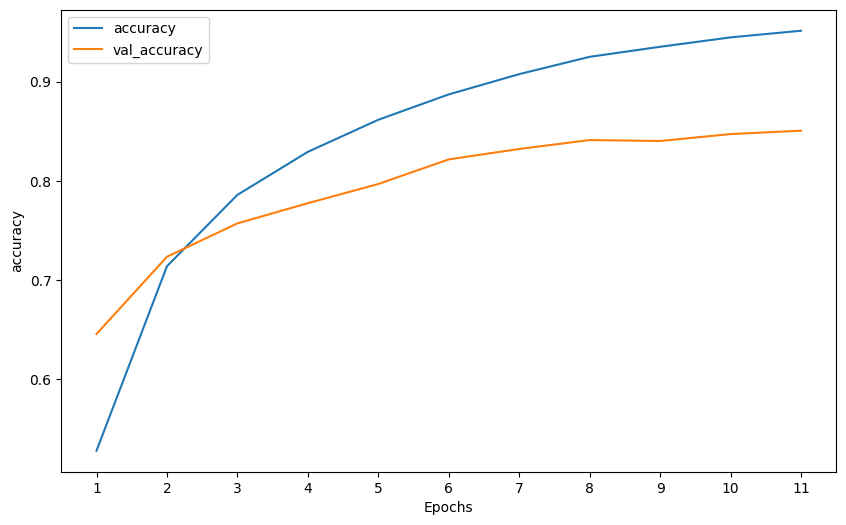

In [34]:
plot_graphs(history, "accuracy")

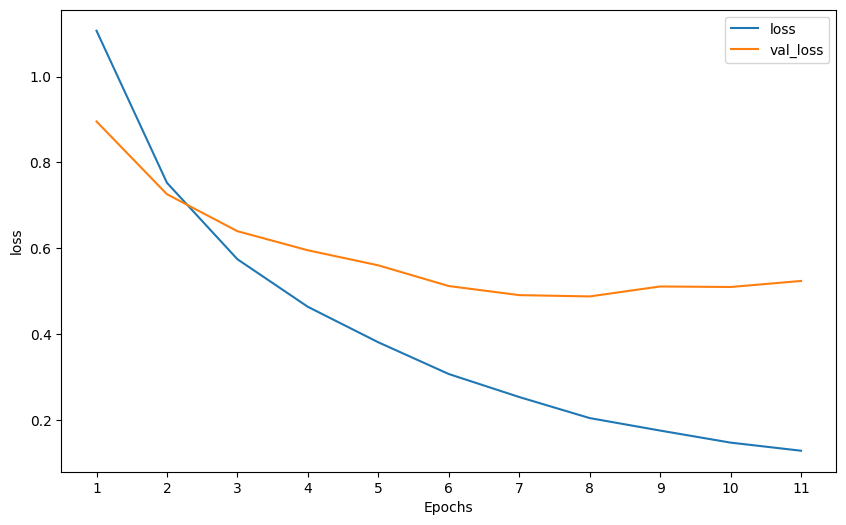

In [35]:
plot_graphs(history, "loss")

In [36]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(np.array(y_test), axis=1)

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


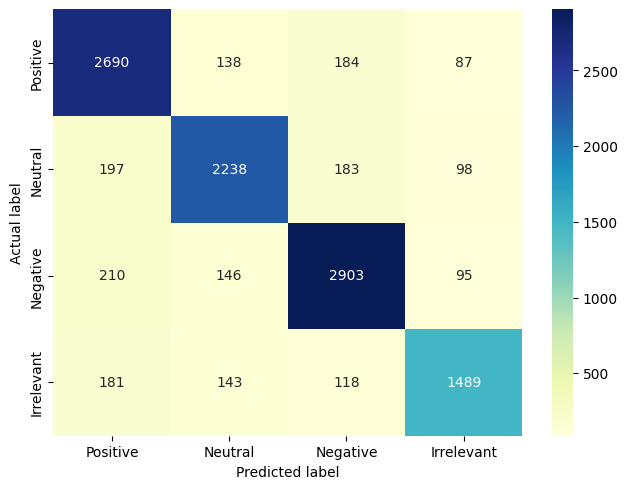

In [37]:
conf = confusion_matrix(y_test2, y_pred_bool)
plot_diagram(conf, model_name)

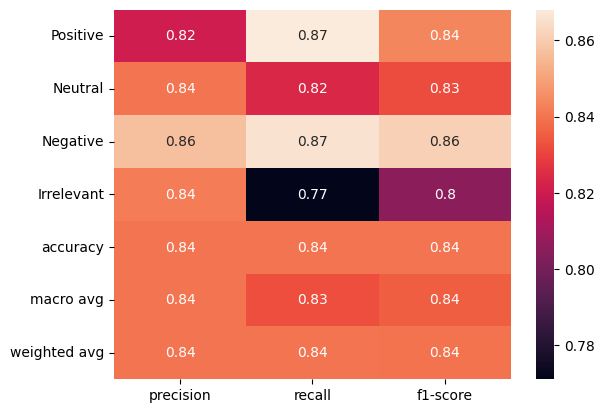

In [38]:
plot_diagram2(y_test2, y_pred_bool, model_name)

In [39]:
result.to_csv('res.csv', index=False)

### **Building a model with BERT**

In [7]:
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [8]:
import torch
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torch import nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score,recall_score,precision_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import os

### **EDA**

In [10]:
m_name = 'bert-base-uncased'
batch_size = 32
epochs = 6

In [11]:
max_length=100

In [12]:
df = pd.read_csv(add, engine='python')
df = df[df[target]!='litigious']
df.head()

,Tweet ID,entity,label,clean-text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
df = df[[target, col]]
df.columns = ['recom', 'comment']

In [14]:
df.recom.value_counts()

,count
recom,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


In [15]:
df.dropna(subset=['recom', 'comment'], inplace=True, how="any")
df.reset_index(drop=True, inplace=True)

In [16]:
possible_labels = df.recom.unique()
possible_labels

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [17]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}

In [18]:
lb = df.recom.unique()
lb

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [19]:
df['label'] = df.recom.replace(label_dict)

/tmp/ipython-input-2792344512.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.recom.replace(label_dict)


In [20]:
df.head()

,recom,comment,label
0,Positive,im getting on borderlands and i will murder yo...,0
1,Positive,I am coming to the borders and I will kill you...,0
2,Positive,im getting on borderlands and i will kill you ...,0
3,Positive,im coming on borderlands and i will murder you...,0
4,Positive,im getting on borderlands 2 and i will murder ...,0


### **Training/Validation Split**

<Axes: >

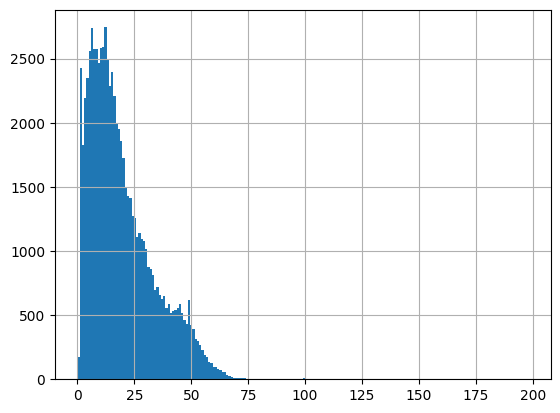

In [21]:
df['len'] = df.comment.str.split().str.len()
df['len'].hist(bins=200)

In [22]:
def plot_graphs(history, string):
    eps = len(history['loss'])
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.ticklabel_format(style='plain', axis='x', useOffset=False)
    plt.plot(range(1, eps+1), history[string])
    plt.plot(range(1, eps+1), history['val_'+string])
    plt.xticks(range(1, eps+1))
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(os.path.join(plot_dir, f"{string}_bert.png"), bbox_inches='tight', dpi=500)
    plt.show()

def plot_diagram(cnf_matrix, name):
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(cnf_matrix, columns=lb, index=lb),
                annot=True, cmap="YlGnBu", fmt='g')
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(result_dir, f"heatmap-{name}_bert.png"), dpi=600, bbox_inches='tight')
    plt.show()

def show_result(y_test, y_pred):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")

def plot_diagram2(y, pred, name):
    global result
    idx = len(result)

    acc = np.round(accuracy_score(y, pred), 3)
    rec = np.round(recall_score(y, pred, average='weighted'), 3)
    prec = np.round(precision_score(y, pred, average='weighted'), 3)
    f1 = np.round(f1_score(y, pred, average='weighted'), 3)

    result.at[idx, 'name'] = name
    result.at[idx, 'accuracy'] = acc
    result.at[idx, 'recall'] = rec
    result.at[idx, 'precison'] = prec
    result.at[idx, 'f1'] = f1
    result.to_csv(result_path, index=False)

    clf_report = classification_report(y, pred, target_names=lb, output_dict=True)
    fig, ax = plt.subplots()
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
    plt.savefig(os.path.join(result_dir, f"{name}_bert.png"), dpi=600, bbox_inches='tight')
    plt.show()

def calc_roc(name, y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred)
    results.append([fpr, tpr, f"{name}, AUC={auc:.3f}"])

In [23]:
def Percentage_of_classes(y_true):
  pc=(len(y_true)/len(df))* 100
  return round(pc,2)

In [24]:
result_path = '/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/clean_datasets/res.csv'
plot_dir = '/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/plots_bert/'
result_dir = '/content/drive/MyDrive/Lstm-CNN project/Lstm-CNN project/result_bert'
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

results = []
df3 = pd.DataFrame({})
df3.to_csv(result_path)
result = pd.read_csv(result_path)

In [25]:
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

In [26]:
tokenizer = BertTokenizer.from_pretrained(m_name,
                                          do_lower_case=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
encoded_data = tokenizer(
    df['comment'].tolist(),
    add_special_tokens=True,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(df['label'].values)

In [28]:
train_inputs, temp_inputs, train_labels, temp_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42
)
train_masks, temp_masks = train_test_split(
    attention_masks, test_size=0.3, random_state=42
)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    temp_inputs, temp_labels, test_size=0.5, random_state=42
)
val_masks, test_masks = train_test_split(
    temp_masks, test_size=0.5, random_state=42
)

In [29]:
print(f"Train set: {Percentage_of_classes(train_labels)} Percentage of samples")
print(f"Validation set: {Percentage_of_classes(val_labels)} Percentage of samples")
print(f"Test set: {Percentage_of_classes(test_labels)} Percentage of samples")

Train set: 70.0 Percentage of samples
Validation set: 15.0 Percentage of samples
Test set: 15.0 Percentage of samples


In [30]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [31]:
class BertCnnLstmClassifier(nn.Module):
    def __init__(self, bert_model_name, num_labels, cnn_filters=64, lstm_hidden=128, dropout=0.3):
        super(BertCnnLstmClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.cnn = nn.Conv1d(in_channels=768, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=lstm_hidden, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, num_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]

        sequence_output = sequence_output.permute(0, 2, 1)
        cnn_out = self.cnn(sequence_output)
        cnn_out = self.relu(cnn_out)

        cnn_out = cnn_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        logits = self.fc(out)
        return logits

In [32]:
print(sorted(df['label'].unique()))


[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [33]:
val_labels

tensor([2, 2, 2,  ..., 2, 0, 1])

In [34]:
print("Train labels:", sorted(train_labels.unique()))
print("Val labels  :", sorted(val_labels.unique()))
print("Test labels :", sorted(test_labels.unique()))


Train labels: [tensor(0), tensor(1), tensor(2), tensor(3)]
Val labels  : [tensor(0), tensor(1), tensor(2), tensor(3)]
Test labels : [tensor(0), tensor(1), tensor(2), tensor(3)]


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
df

,recom,comment,label,len
0,Positive,im getting on borderlands and i will murder yo...,0,11
1,Positive,I am coming to the borders and I will kill you...,0,12
2,Positive,im getting on borderlands and i will kill you ...,0,10
3,Positive,im coming on borderlands and i will murder you...,0,10
4,Positive,im getting on borderlands 2 and i will murder ...,0,12
...,...,...,...,...
73991,Positive,Just realized that the Windows partition of my...,0,26
73992,Positive,Just realized that my Mac window partition is ...,0,23
73993,Positive,Just realized the windows partition of my Mac ...,0,25
73994,Positive,Just realized between the windows partition of...,0,32


In [37]:
model = BertCnnLstmClassifier(m_name, num_labels=4).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [38]:
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_preds, train_labels_list = [], []
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        logits = model(b_input_ids, b_attention_mask)
        loss = criterion(logits, b_labels)
        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels_list.extend(b_labels.cpu().numpy())

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(train_accuracy)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}")

    model.eval()
    val_loss = 0
    val_preds, val_labels_list = [], []
    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
            logits = model(b_input_ids, b_attention_mask)
            loss = criterion(logits, b_labels)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(b_labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(val_labels_list, val_preds)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}, F1-Score: {f1_score(val_labels_list, val_preds, average='weighted'):.3f}")

Epoch 1:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.018, Training Accuracy: 0.595
Validation Loss: 0.810, Validation Accuracy: 0.697, F1-Score: 0.689


Epoch 2:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.622, Training Accuracy: 0.778
Validation Loss: 0.593, Validation Accuracy: 0.789, F1-Score: 0.789


Epoch 3:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.373, Training Accuracy: 0.873
Validation Loss: 0.487, Validation Accuracy: 0.836, F1-Score: 0.835


Epoch 4:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.258, Training Accuracy: 0.914
Validation Loss: 0.451, Validation Accuracy: 0.853, F1-Score: 0.853


Epoch 5:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.203, Training Accuracy: 0.930
Validation Loss: 0.431, Validation Accuracy: 0.861, F1-Score: 0.861


Epoch 6:   0%|          | 0/1619 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.172, Training Accuracy: 0.940
Validation Loss: 0.421, Validation Accuracy: 0.867, F1-Score: 0.867


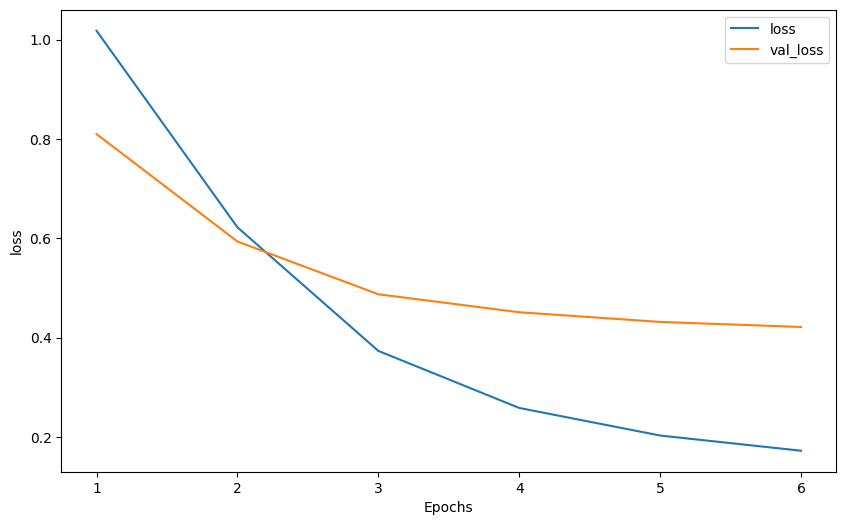

In [39]:
plot_graphs(history, 'loss')

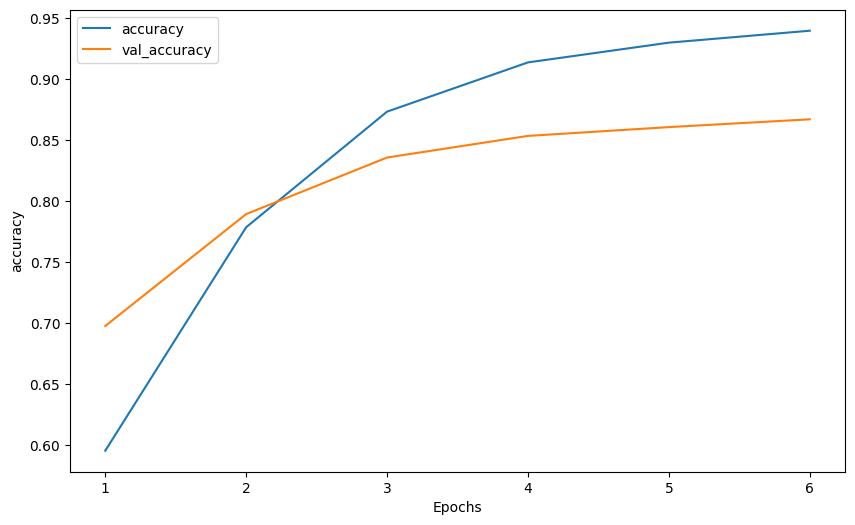

In [40]:
plot_graphs(history, 'accuracy')

In [41]:
model.eval()
test_preds, test_labels_list = [], []
test_probs = []
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]
        logits = model(b_input_ids, b_attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(b_labels.cpu().numpy())
        test_probs.extend(probs)

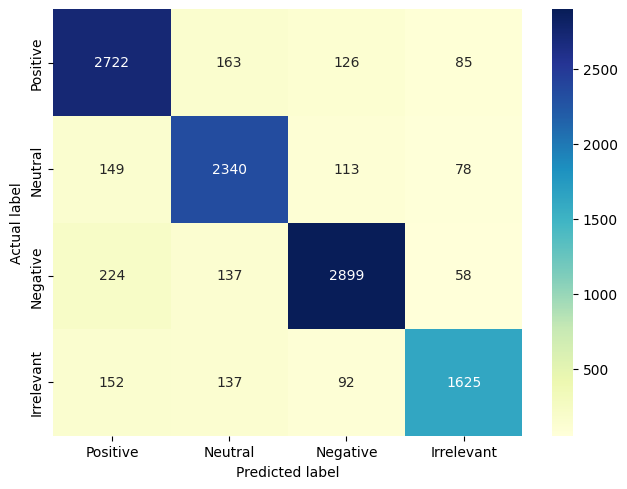

In [42]:
plot_diagram(confusion_matrix(test_labels_list, test_preds), 'bert_cnn_lstm')

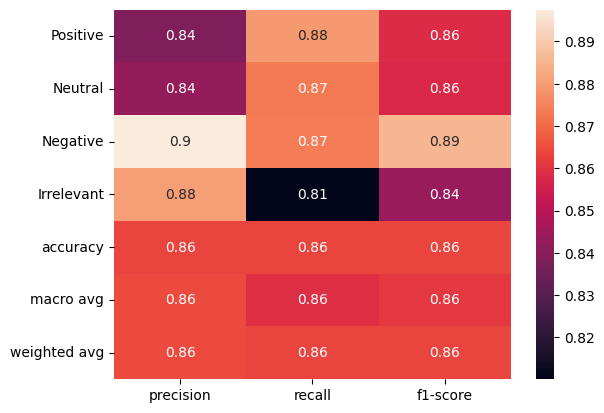

In [43]:
plot_diagram2(test_labels_list, test_preds, 'bert_cnn_lstm')

## **Conclusion:**
**Word2Vec** models convert each word into a fixed vector that represents the general meaning of that word, but this vector is the same for all sentences and does not change. That is, "cold" in the sentences "The food was cold" and "He is not a cold person" will have exactly one vector, so it does not understand the context of the sentence. Word2Vec itself only performs vectorization and for tasks such as emotion recognition, we need to give its output to another model such as Logistic Regression, SVM or LSTM to perform classification.

However, **BERT** is a bidirectional transformer model that encodes the word based on the context of the sentence, meaning that if the word "cold" appears in two different sentences, two different vectors are created for it. This makes it better at understanding negation, sarcasm, emotional intensity and ambiguity. In BERT, vectorization and classification training are performed simultaneously and the output can be sent directly to the positive or negative category with a simple layer on the \[CLS] token.

Typically, models built with BERT have higher accuracy on sentiment recognition datasets, especially Persian—typically between 3 and 15 percent higher than the combination of Word2Vec and classical models. This advantage is due to BERT’s ability to understand context and word-by-word relationships. The exception is when the dataset is very small or there are severe hardware limitations, as BERT is heavier and runs faster on GPUs. In these cases, lighter versions such as DistilBERT or MiniLM can be used.